In [142]:
import jax.numpy as np
import matplotlib.pyplot as plt
import dLux as dl
import dLux.utils as dlu
import jax.random as jr
import dLuxToliman as dlT
import optax
import zodiax as zdx
import jax
from tqdm.notebook import tqdm
import numpyro as npy
import numpyro.distributions as dist
from jax import device_count

In [272]:
wf_npix = 256 # gonna do double the psf_npix
diameter = 0.125
coords = dlu.pixel_coords(wf_npix, diameter)
aperture = dlu.circle(coords, 0.5*diameter)
wavelength = 585e-9

# this is basically half of louis 
psf_npix = 128
psf_pixel_scale = dlu.rad2arcsec(wavelength/(2*diameter))
# nyquist = lambda/2D
oversample = 4 #fairly shite.. hopefully doesn't come back to bite us

pupil = dlT.TolimanPupilLayer(wf_npix)

# defining the defocus model, the super gaussian
psf_diameter = psf_pixel_scale*psf_npix #arcsec
psf_coords = dlu.pixel_coords(psf_npix*oversample/3.2, psf_diameter/3.2)

X, Y = psf_coords
R = np.sqrt(X**2 + Y**2)

# parameters
sigma = psf_diameter/8
n = 4

super_gaussian = np.exp(-(R**2/sigma**2)**n)
# this works but is like not correctly parameterised. it should be everything relative to the psf rather than wf.

layers = [
    (
        'aperture',
        dl.layers.TransmissiveLayer(aperture, normalise=True)
    )
]

layers_tol = [
    (
        'aperture',
        dl.layers.TransmissiveLayer(aperture, normalise=True)
    ),
    (
        'pupil',
        pupil
    )
]

optics = dl.AngularOpticalSystem(
    wf_npix, diameter, layers, psf_npix, psf_pixel_scale, oversample
)

optics_tol = dl.AngularOpticalSystem(
    wf_npix, diameter, layers_tol, psf_npix, psf_pixel_scale, oversample
)

flux = 10000

position_arcsec = jr.uniform(jr.PRNGKey(0), (2,), minval=-16*psf_pixel_scale, maxval=16*psf_pixel_scale)
position_rad = dlu.arcsec2rad(position_arcsec)
position_rad_2 = dlu.arcsec2rad(position_arcsec - np.array([-0.01,0]))
print(position_arcsec)
print(position_rad)
print(position_rad_2)

source = dl.PointSource(np.array([wavelength]), position=position_rad, flux=flux)

source_diff = dl.PointSource(np.array([wavelength]), position=position_rad_2, flux=flux)

diffuse_source = dl.ResolvedSource(np.array([wavelength]), position=position_rad, flux=flux, distribution=super_gaussian)

downsample = 64
downsample_layer = dl.layers.detector_layers.Downsample(downsample)
detector = dl.LayeredDetector([downsample_layer])

telescope = dl.Telescope(optics, source, detector)
telescope_tol = dl.Telescope(optics_tol, source, detector)
telescope_diffuser = dl.Telescope(optics, diffuse_source, detector)
telescope_diff = dl.Telescope(optics, source_diff, detector)
telescope_diff_tol = dl.Telescope(optics_tol, source_diff, detector)

[-4.381849  4.69723 ]
[-2.1243803e-05  2.2772814e-05]
[-2.1195321e-05  2.2772814e-05]


In [273]:
print(psf_npix*oversample)

512


In [274]:
psf_diffuser = telescope_diffuser.model()
psf_tol = telescope_tol.model()
psf = telescope.model()
psf_diff = telescope_diff.model()
psf_diff_tol = telescope_diff_tol.model()

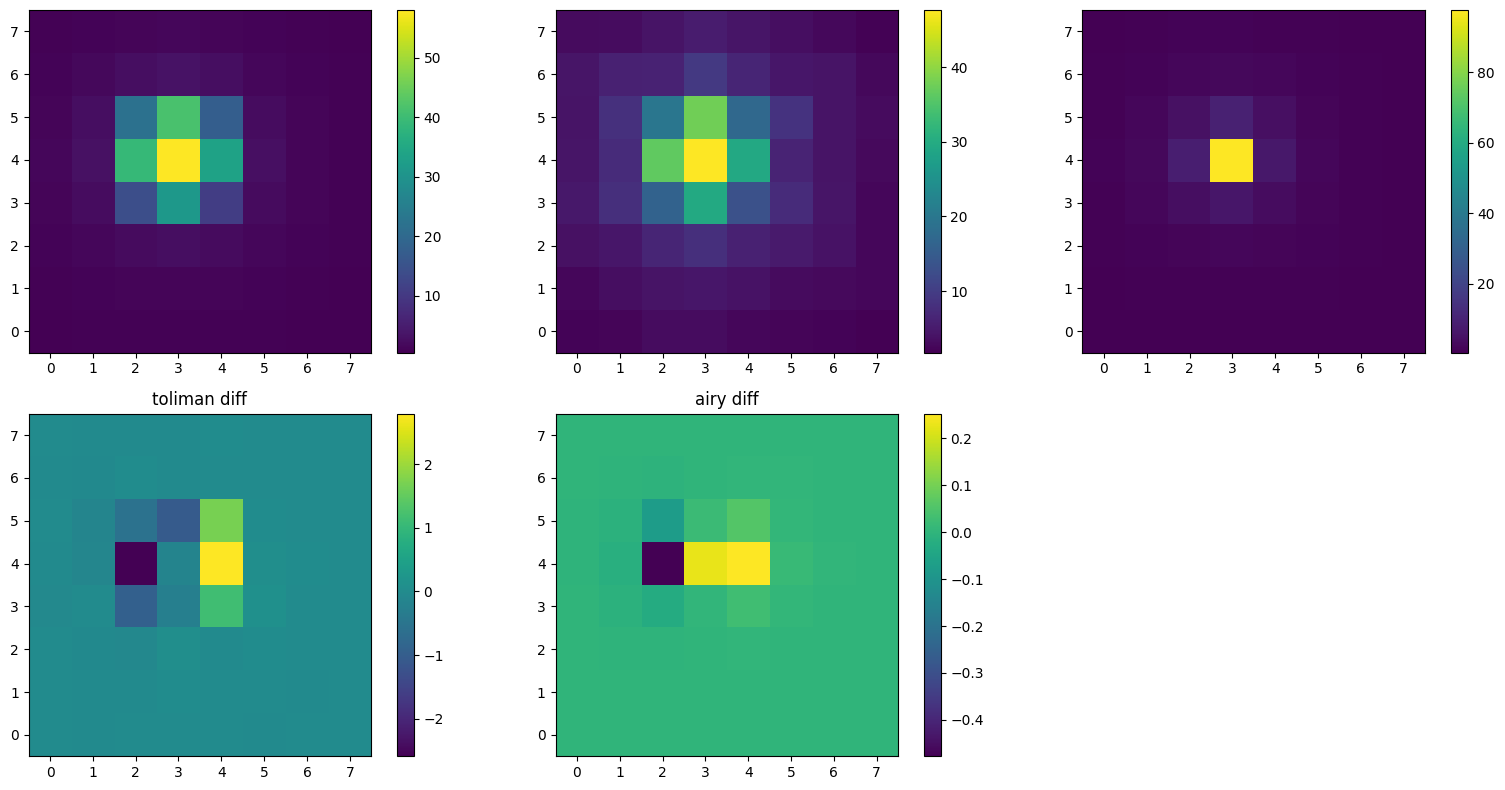

[[False  True False False False  True False False]
 [ True  True  True False False False  True False]
 [False  True  True False  True False False False]
 [ True False  True  True False False False False]
 [ True  True  True  True False False False  True]
 [ True  True  True  True False False False False]
 [ True  True False  True False False False False]
 [ True  True  True  True False False  True False]]
[[ True  True  True  True False False False False]
 [ True  True  True  True False False False False]
 [ True  True  True False False False False False]
 [ True  True  True False False False False False]
 [ True  True  True False False False False False]
 [ True  True  True False False False False False]
 [ True  True  True False False False False False]
 [ True  True  True False False False False False]]
12.273544
1.2688916


In [275]:
plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.imshow(psf_diffuser**0.5,origin='lower')
plt.colorbar()

plt.subplot(2,3,2)
plt.imshow(psf_tol**0.5,origin='lower')
plt.colorbar()

plt.subplot(2,3,3)
plt.imshow(psf**0.5,origin='lower')
plt.colorbar()

plt.subplot(2,3,4)
plt.title(
    'toliman diff'
)
plt.imshow(psf_diff_tol-psf_tol,origin='lower')
plt.colorbar()

plt.subplot(2,3,5)
plt.title('airy diff')
plt.imshow(psf_diff-psf,origin='lower')
plt.colorbar()

plt.tight_layout()
plt.show()

# print(np.sum(psf_diffuser))
# print(np.sum(psf_tol))

print(psf_diff_tol-psf_tol < 0)
print(psf_diff - psf < 0)
print(np.sum(np.abs(psf_diff_tol-psf_tol)))
print(np.sum(np.abs(psf_diff-psf)))

In [281]:
8/dlu.rad2arcsec(wavelength/(2*0.125))

16.57482670459952

In [211]:
parameters = ['position', 'flux']

def psf_model(data, model):

    x = dlu.arcsec2rad(npy.sample("x_pos", dist.Uniform(-18*psf_pixel_scale,18*psf_pixel_scale)))
    y = dlu.arcsec2rad(npy.sample("y_pos", dist.Uniform(-18*psf_pixel_scale,18*psf_pixel_scale)))

    flux = npy.sample("flux", dist.Uniform(0.9*10000,1.1*10000))

    values = [
        np.array([x,y]),
        flux
    ]

    with npy.plate("data", len(data.flatten())):
        poisson_model = dist.Poisson(
            model.set(parameters, values).model().flatten()
        )
        return npy.sample("psf", poisson_model, obs=data.flatten())

In [212]:
sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model),
    num_warmup=200,
    num_samples=200,
    num_chains=device_count(),
    progress_bar=True
)

In [213]:
data = jr.poisson(jr.PRNGKey(0), telescope.model())

In [214]:
%time sampler.run(jr.PRNGKey(0), data, telescope)

sample: 100%|██████████| 400/400 [00:42<00:00,  9.32it/s, 3 steps of size 5.67e-01. acc. prob=0.94] 

CPU times: user 3min 13s, sys: 7.15 s, total: 3min 21s
Wall time: 43.1 s


In [215]:
sampler.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      flux  10016.43     98.84  10011.90   9851.65  10156.21     88.57      1.02
     x_pos     -7.01      0.01     -7.01     -7.03     -6.99    215.21      1.00
     y_pos      6.29      0.04      6.29      6.23      6.37    101.21      1.00

Number of divergences: 0


In [165]:
sampler.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      flux  10005.32     93.41   9999.32   9868.25  10174.99    163.08      1.00
     x_pos     -1.43      0.05     -1.43     -1.50     -1.36    250.47      1.00
     y_pos      1.47      0.05      1.46      1.39      1.53    158.87      1.00

Number of divergences: 0


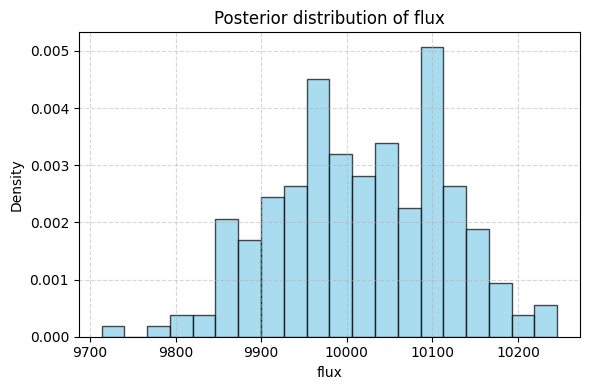

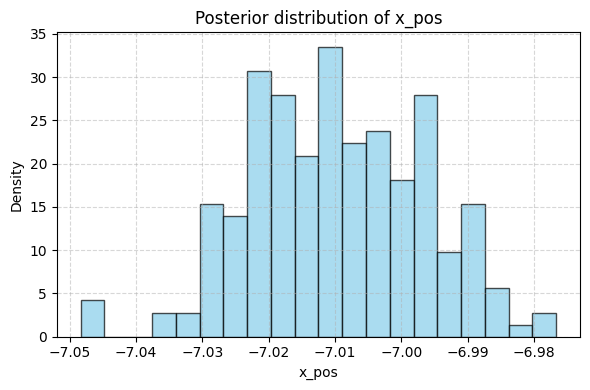

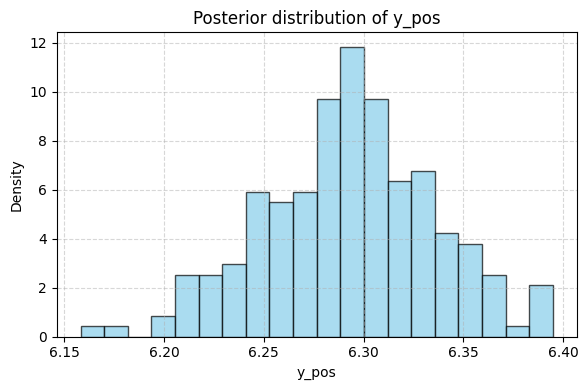

In [218]:
samples = sampler.get_samples()
for param, values in samples.items():
    plt.figure(figsize=(6, 4))
    plt.hist(values.flatten(), bins=20, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f"Posterior distribution of {param}")
    plt.xlabel(param)
    plt.ylabel("Density")
    #plt.xlim((1-0.02*np.sqrt(1000)/np.sqrt(flux))*wavelength,(1+0.02*np.sqrt(1000)/np.sqrt(flux))*wavelength)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()